In [24]:
# @title
# Setup
# https://pyod.readthedocs.io/en/latest/
# pyod for libraries in anomaly detection
#

# === CONFIGURATION ===
# Choose which dataset to use
DATASET_MODE = "RT-IOT2022"
# options: "RT-IOT2022", "cic-ids2018",

# Enable lightweight mode to avoid OOM
# LIGHT_MODE = True          # set False for full data
CHUNK_SIZE = 20000         # adjust for Colab (50k–100k recommended)
SAMPLE_LIMIT = 40000
LIGHT_MODE = False


In [25]:
# Setup
!pip3 install -U tensorflow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report,
    roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
# from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model


In [26]:

if DATASET_MODE == "RT-IOT2022":
    !pip3 install -U ucimlrepo
    from ucimlrepo import fetch_ucirepo

    dataset = fetch_ucirepo(id=942)
    X = dataset.data.features
    y = dataset.data.targets
    benign_labels = ['Thing_Speak', 'MQTT_Publish', 'NMAP_XMAS_TREE_SCAN', 'NMAP_TCP_scan',
                 'NMAP_OS_DETECTION', 'NMAP_UDP_SCAN', 'Wipro_bulb', 'NMAP_FIN_SCAN',
                 'DOS_SYN_Hping']
    malicious_column = "Attack_type"
    EXCLUDE_FROM_SCALING = []
    #benign_labels = ['Thing_Speak', 'MQTT_Publish', 'Wipro_bulb',
    #                 'NMAP_FIN_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
    #                 'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN']


elif DATASET_MODE == "cic-ids2018-fri02":
    benign_labels = ['Benign']
    malicious_column = "Label"
    EXCLUDE_FROM_SCALING = ['time_sin', 'time_cos']

    filename = "/content/drive/MyDrive/datasets-anomaly-detection/CIC-IDS2018/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv"
    with pd.read_csv(filename, chunksize=SAMPLE_LIMIT, low_memory=True) as df:
      df = next(df)
      # Attempt to parse timestamp automatically
      df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

      # Extract hour, minute, and second
      df["hour"] = df["Timestamp"].dt.hour.fillna(0)
      df["minute"] = df["Timestamp"].dt.minute.fillna(0)
      df["second"] = df["Timestamp"].dt.second.fillna(0)

      # Compute cyclical time features
      df["time_sin"] = np.sin(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))
      df["time_cos"] = np.cos(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))

      # Drop timestamp and raw time components (keep only sin/cos)
      df = df.drop(columns=["Timestamp", "hour", "minute", "second"])
      X = df.drop(columns=[malicious_column])
      y = df[[malicious_column]] if malicious_column in df.columns else None
      print(f"Loaded chunk shape: {df.shape}")

elif DATASET_MODE == "cic-ids2018-fri23":
    benign_labels = ['Benign']
    malicious_column = "Label"
    EXCLUDE_FROM_SCALING = ['time_sin', 'time_cos']

    filename = "/content/drive/MyDrive/datasets-anomaly-detection/CIC-IDS2018/Friday-23-02-2018_TrafficForML_CICFlowMeter.csv"

    df =  pd.read_csv(filename, low_memory=True)
    # Attempt to parse timestamp automatically
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

    # Extract hour, minute, and second
    df["hour"] = df["Timestamp"].dt.hour.fillna(0)
    df["minute"] = df["Timestamp"].dt.minute.fillna(0)
    df["second"] = df["Timestamp"].dt.second.fillna(0)

    # Compute cyclical time features
    df["time_sin"] = np.sin(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))
    df["time_cos"] = np.cos(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))

    # Drop timestamp and raw time components (keep only sin/cos)
    df = df.drop(columns=["Timestamp", "hour", "minute", "second"])

    X = df.drop(columns=[malicious_column])
    y = df[[malicious_column]] if malicious_column in df.columns else None
    print(f"Loaded chunk shape: {df.shape}")

elif DATASET_MODE == "TON-IoT-Fridge":
  benign_labels = False
  malicious_column = "label"
  EXCLUDE_FROM_SCALING = ['label', 'time_sin', 'time_cos']

  filename = "/content/drive/MyDrive/datasets-anomaly-detection/TON-IoT/Train_Test_IoT_Fridge.csv"
  df = pd.read_csv(filename, low_memory=True)
  df["Timestamp"] = pd.to_datetime(df["time"], errors="coerce")

  # Extract hour, minute, and second
  df["hour"] = df["Timestamp"].dt.hour.fillna(0)
  df["minute"] = df["Timestamp"].dt.minute.fillna(0)
  df["second"] = df["Timestamp"].dt.second.fillna(0)

  # Compute cyclical time features
  df["time_sin"] = np.sin(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))
  df["time_cos"] = np.cos(2 * np.pi * ((df["hour"] + (df["minute"] + df["second"] / 60) / 60) / 24))

  # Drop timestamp and raw time components (keep only sin/cos)
  df = df.drop(columns=["Timestamp", "hour", "minute", "second", "time", 'date', 'type'])

  df['temp_condition'] = df['temp_condition'].astype(str).str.strip()

  X = df.drop(columns=[malicious_column])
  y = df[[malicious_column]] if malicious_column in df.columns else None
  print(f"Loaded chunk shape: {df.shape}")


print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Initial column names: {X.columns.values}")


X shape: (123117, 83)
y shape: (123117, 1)
Initial column names: ['id.orig_p' 'id.resp_p' 'proto' 'service' 'flow_duration' 'fwd_pkts_tot'
 'bwd_pkts_tot' 'fwd_data_pkts_tot' 'bwd_data_pkts_tot' 'fwd_pkts_per_sec'
 'bwd_pkts_per_sec' 'flow_pkts_per_sec' 'down_up_ratio'
 'fwd_header_size_tot' 'fwd_header_size_min' 'fwd_header_size_max'
 'bwd_header_size_tot' 'bwd_header_size_min' 'bwd_header_size_max'
 'flow_FIN_flag_count' 'flow_SYN_flag_count' 'flow_RST_flag_count'
 'fwd_PSH_flag_count' 'bwd_PSH_flag_count' 'flow_ACK_flag_count'
 'fwd_URG_flag_count' 'bwd_URG_flag_count' 'flow_CWR_flag_count'
 'flow_ECE_flag_count' 'fwd_pkts_payload.min' 'fwd_pkts_payload.max'
 'fwd_pkts_payload.tot' 'fwd_pkts_payload.avg' 'fwd_pkts_payload.std'
 'bwd_pkts_payload.min' 'bwd_pkts_payload.max' 'bwd_pkts_payload.tot'
 'bwd_pkts_payload.avg' 'bwd_pkts_payload.std' 'flow_pkts_payload.min'
 'flow_pkts_payload.max' 'flow_pkts_payload.tot' 'flow_pkts_payload.avg'
 'flow_pkts_payload.std' 'fwd_iat.min' 'fwd_ia

In [27]:

# TODO: drop NaN or invalid
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]

# TODO: preprocess X using one-hot encoder
# cat_cols = X.select_dtypes(include=["object", "category"]).columns
# encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# X_encoded = encoder.fit_transform(X[cat_cols])
# Create DataFrame for encoded features
# encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(cat_cols), index=X.index)
# Combine encoded categorical features with numerical ones
# num_df = X.drop(columns=cat_cols)
# X_processed = pd.concat([num_df, encoded_df], axis=1)

# TODO: normalize input features
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns


numeric_transformer = Pipeline([
#    ('log', FunctionTransformer(lambda x: np.log1p(np.abs(x)))),
    ('log', FunctionTransformer(np.vectorize(lambda x: np.log1p(abs(x))) if len(X) < 5e5 else FunctionTransformer(lambda x: x))),  # skip log on big data
    ('scaler', RobustScaler(quantile_range=(5, 95)))
    # ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=True)


preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])



# Fit on a sample to reduce memory if data huge
sample_rows = min(SAMPLE_LIMIT, len(X))
X_sample = X.sample(sample_rows, random_state=42)
preprocessor.fit(X_sample)

if LIGHT_MODE:
  # Transform in smaller batches
  def transform_in_chunks(preprocessor, X, chunk_size=CHUNK_SIZE):
      chunks = []
      for i in range(0, len(X), chunk_size):
          X_chunk = X.iloc[i:i+chunk_size]
          X_trans = preprocessor.transform(X_chunk)
          chunks.append(X_trans)
      return np.vstack([c.toarray() if hasattr(c, "toarray") else c for c in chunks])
  print("Transform")
  # Apply transformation safely
  X_scaled = transform_in_chunks(preprocessor, X)
else:
# Apply transformations
  X_scaled = preprocessor.fit_transform(X)

# print(np.min(X_scaled), np.max(X_scaled))
# print(np.mean(X_scaled), np.std(X_scaled))


# Get proper column names
num_features = num_cols
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_features, cat_features])

# Construct final DataFrame
X = pd.DataFrame(X_scaled, columns=feature_names, index=X.index)

print(f"Numeric cols: {len(num_cols)}, Categorical cols: {len(cat_cols)}")
print(f"Final feature count: {X.shape[1]}")
print(X.head())

print(cat_cols)
print(X.shape)
print(y.shape)

# metadata
# print(rt_iot2022.metadata)
# variable information
# print(rt_iot2022.variables)


Numeric cols: 81, Categorical cols: 2
Final feature count: 94
   id.orig_p  id.resp_p  flow_duration  fwd_pkts_tot  bwd_pkts_tot  \
0   0.013114   0.809912       2.569702           1.0      0.564575   
1   0.109334   0.809912       2.566847           1.0      0.564575   
2   0.063471   0.809912       2.572201           1.0      0.564575   
3   0.169375   0.809912       2.568576           1.0      0.564575   
4   0.108957   0.809912       2.567266           1.0      0.564575   

   fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  bwd_pkts_per_sec  \
0                0.5           0.861353         -0.877755         -0.885158   
1                0.5           0.861353         -0.877692         -0.885119   
2                0.5           0.861353         -0.877811         -0.885192   
3                0.5           0.861353         -0.877730         -0.885143   
4                0.5           0.861353         -0.877701         -0.885125   

   flow_pkts_per_sec  ...  service_-  serv

In [28]:
y_benign = y.loc[y[malicious_column].isin(benign_labels)]
y_malicious = y.loc[~y[malicious_column].isin(benign_labels)]

# Print ratio benign and malicious
print(f"Benign ratio: {len(y_benign) / len(y):.2f}")
print(f"Malicious ratio: {len(y_malicious) / len(y):.2f}")


train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10
# Split benign data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X.loc[y_benign.index], y_benign, test_size=1 - train_ratio, random_state=4
)
# Split training data into training and validation sets
# 75/25 of benign training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=test_ratio/(test_ratio + validation_ratio), random_state=4
)

# Combine benign test data and malicious data for the overall test set
X_test = pd.concat([X_test, X.loc[y_malicious.index]])
y_test = pd.concat([y_test, y_malicious])

# X_train, y_train -> benign training dataset -> (10630, 83), (10630, 1)
# X_test_benign, y_test_benign -> benign testing dataset -> (1877, 83), (1877, 1)
# X_test, y_test -> benign + malicious training dataset -> (112487, 83), (112487, 1)

Benign ratio: 0.93
Malicious ratio: 0.07


In [29]:
print(y.loc[y[malicious_column].isin(['ARP_poisioning', 'DOS_SYN_Hping'])].size)

102409


In [30]:
print("Benign label y_train", y_train[malicious_column].unique())
print(X_train.shape)
print("Benign testing y_test_benign", y_test[malicious_column].unique())
print(X_test.shape)
print("Benign validation y_val", y_val[malicious_column].unique())
print(X_val.shape)
print("Malicious label y_test", y_test[malicious_column].unique())
print(X_test.shape)

Benign label y_train ['DOS_SYN_Hping' 'Thing_Speak' 'NMAP_TCP_scan' 'NMAP_OS_DETECTION'
 'MQTT_Publish' 'NMAP_UDP_SCAN' 'NMAP_XMAS_TREE_SCAN' 'Wipro_bulb'
 'NMAP_FIN_SCAN']
(51658, 94)
Benign testing y_test_benign ['DOS_SYN_Hping' 'Thing_Speak' 'MQTT_Publish' 'NMAP_UDP_SCAN' 'Wipro_bulb'
 'NMAP_TCP_scan' 'NMAP_OS_DETECTION' 'NMAP_XMAS_TREE_SCAN' 'NMAP_FIN_SCAN'
 'ARP_poisioning' 'DDOS_Slowloris' 'Metasploit_Brute_Force_SSH']
(37020, 94)
Benign validation y_val ['Thing_Speak' 'DOS_SYN_Hping' 'NMAP_UDP_SCAN' 'NMAP_TCP_scan'
 'NMAP_XMAS_TREE_SCAN' 'NMAP_OS_DETECTION' 'MQTT_Publish' 'Wipro_bulb'
 'NMAP_FIN_SCAN']
(34439, 94)
Malicious label y_test ['DOS_SYN_Hping' 'Thing_Speak' 'MQTT_Publish' 'NMAP_UDP_SCAN' 'Wipro_bulb'
 'NMAP_TCP_scan' 'NMAP_OS_DETECTION' 'NMAP_XMAS_TREE_SCAN' 'NMAP_FIN_SCAN'
 'ARP_poisioning' 'DDOS_Slowloris' 'Metasploit_Brute_Force_SSH']
(37020, 94)


In [31]:
class AnomalyDetector(Model):
  def __init__(self, input_dim, activation):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(48, activation=activation),
      layers.Dense(16, activation=activation),
      layers.Dense(8, activation=activation)])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation=activation),
      layers.Dense(48, activation=activation),
      layers.Dense(input_dim, activation="linear")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


autoencoder = AnomalyDetector(input_dim=X_train.shape[1], activation="relu")
autoencoder.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history = autoencoder.fit(X_train, X_train,
          epochs=500,
          batch_size=512,
          validation_data=(X_val, X_val),
          shuffle=True,
          callbacks=[es])

Epoch 1/500
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.4041 - val_loss: 0.0326
Epoch 2/500
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0265 - val_loss: 0.0112
Epoch 3/500
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0101 - val_loss: 0.0068
Epoch 4/500
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0067 - val_loss: 0.0055
Epoch 5/500
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0059 - val_loss: 0.0051
Epoch 6/500
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 7/500
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 8/500
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 9/500
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 10/500
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 11/500
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 12/500
101/101 ━━━━━━━━━━━

1157/1157 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99     28699
     Anomaly       0.95      0.98      0.96      8321

    accuracy                           0.98     37020
   macro avg       0.97      0.98      0.98     37020
weighted avg       0.98      0.98      0.98     37020


Accuracy:  0.9836
Precision: 0.9508
Recall:    0.9776
F1-score:  0.9640
AUC:       0.9948


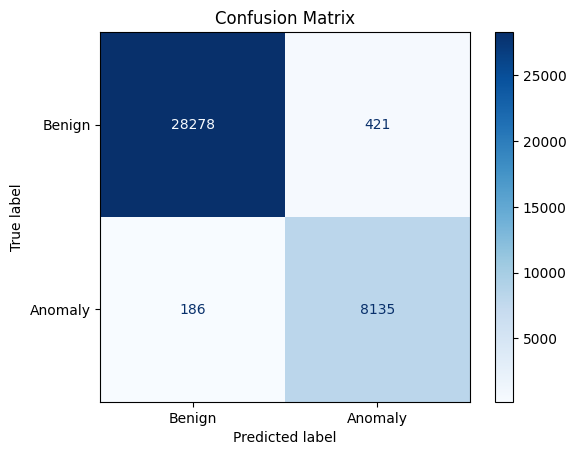

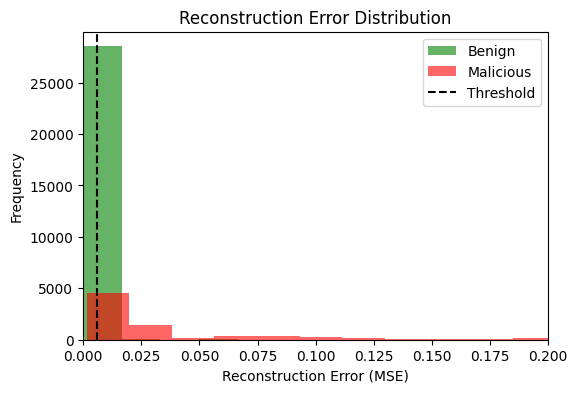

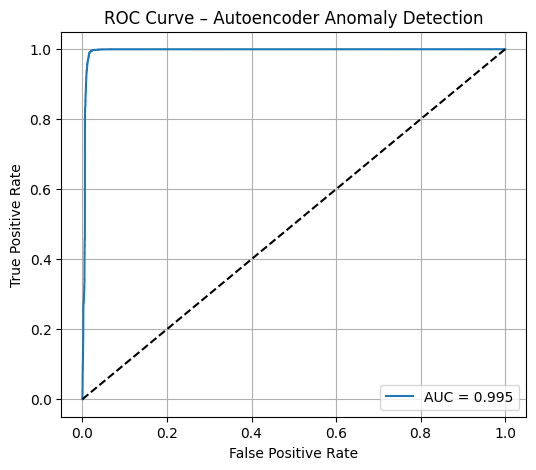

In [78]:
#
reconstructions = autoencoder.predict(X_test)
loss = np.mean((X_test.to_numpy() - reconstructions)**2, axis=1)  # ensure numpy arrays

#
benign_mask = y_test[malicious_column].isin(benign_labels).values
y_true = (~benign_mask).astype(int)  # 0 = benign, 1 = malicious

#
val_recon = autoencoder.predict(X_val)
val_loss = np.mean(np.abs(X_val.to_numpy() - val_recon), axis=1)

def best_threshold(y_true, loss):
    thresholds = np.linspace(np.min(loss), np.max(loss), 2000)
    f1_scores = [f1_score(y_true, (loss > t).astype(int)) for t in thresholds]
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    print(f"Best threshold: {best_threshold:.5f}, Best F1: {f1_scores[best_idx]:.4f}")
    return best_threshold

def mad_threshold(val_loss, k):
    med = np.median(val_loss)
    mad = np.median(np.abs(val_loss - med))
    return med + k * mad

threshold = mad_threshold(val_loss, k=6.0)
#
# threshold = best_threshold(y_true, loss)
#threshold = np.mean(val_loss) + 1 * np.std(val_loss)
#print(f"Threshold: {threshold:.5f}")


#
y_pred = (loss > threshold).astype(int)

#
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)
auc  = roc_auc_score(y_true, loss)

print(classification_report(y_true, y_pred, target_names=["Benign", "Anomaly"]))


print(f"\nAccuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Anomaly"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

#
plt.figure(figsize=(6,4))
plt.hist(loss[benign_mask], bins=50, alpha=0.6, label='Benign', color="green")
plt.hist(loss[~benign_mask], bins=50, alpha=0.6, label='Malicious', color="red")
plt.axvline(x=threshold, color='black', linestyle='--', label='Threshold')
plt.xlim(0, 0.2)
plt.legend()
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Distribution")
plt.show()

#
fpr, tpr, _ = roc_curve(y_true, loss)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Autoencoder Anomaly Detection")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()